# Some studies about Delta-z effect


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

from   scipy             import optimize

to_df = pd.DataFrame.from_records

import invisible_cities.core.fit_functions as fitf

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Nov 18 17:42:26 2020


### Load data

In [5]:
def get_filename(run_number):
    datadir    = f"/data_extra2/jrenner/analysis/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
    return filename

def append_dfs(dfs):
    df = None
    for i, idf in enumerate(dfs):
        df = idf if i == 0 else df.append(idf, ignore_index = True)
    return df

In [6]:
runs      = [8180, 8182, 8183, 8184]
filenames = [get_filename(run) for run in runs]
dds       = [bes.get_df_zeffect(filename) for filename in filenames]
dd        = append_dfs(dds)

In [7]:
dd['S2eq']      = dd['S2e']/dd['S2q']
dd['blob1_eta'] = (dd['blob1_z'] - dd['z_min'])/dd['dz_track']
dd['blob2_eta'] = (dd['blob2_z'] - dd['z_min'])/dd['dz_track']

print(len(dd))
print(list(dd.columns))

3981480
['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'S2eq', 'blob1_eta', 'blob2_eta']


In [25]:
ranges                   = bes.get_ranges()

ranges['eblob2.soft']    = (0.2, 1.)

ranges['nS2.one']        = (0.5, 1.5)
#ranges['S2e']            = (2.5e5, 1e8)

ranges['energy.ph']      = (2.6, 3.0)

ranges['energy.cs.hard'] = (0.671, 0.691)
ranges['energy.ds.hard'] = (1.630, 1.700)
ranges['energy.ph.hard'] = (2.700, 2.900)

ranges['enecor.cs.hard'] = (0.671, 0.691)
ranges['enecor.ds.hard'] = (1.630, 1.700)
ranges['enecor.ph.hard'] = (2.700, 2.900)

ranges['dz_track.cs.hard'] = ( 8.,  32.)
ranges['dz_track.ds.hard'] = (40.,  80.)
ranges['dz_track.ph.hard'] = (40., 100.)

ranges['blob1_eta.right']  = (0.8, 1.0)
ranges['blob1_eta.left' ]  = (0. , 0.2)

print('ranges', [(key, ranges[key]) for key in ranges.keys()])

ranges [('numb_of_tracks.one', (0.5, 1.5)), ('energy', (0.0, 3.0)), ('energy.cs', (0.65, 0.71)), ('energy.ds', (1.55, 1.75)), ('energy.ph', (2.6, 3.0)), ('enecor.cs', (0.65, 0.71)), ('enecor.ds', (1.55, 1.75)), ('enecor.ph', (2.5, 3.0)), ('z_min', (50.0, 500.0)), ('z_max', (50.0, 500.0)), ('r_max', (0.0, 180.0)), ('dz_track.cs', (8.0, 32.0)), ('dz_track.ds', (24.0, 72.0)), ('dz_track.ph', (35.0, 130.0)), ('eblob2.soft', (0.2, 1.0)), ('nS2.one', (0.5, 1.5)), ('energy.cs.hard', (0.671, 0.691)), ('energy.ds.hard', (1.63, 1.7)), ('energy.ph.hard', (2.7, 2.9)), ('enecor.cs.hard', (0.671, 0.691)), ('enecor.ds.hard', (1.63, 1.7)), ('enecor.ph.hard', (2.7, 2.9)), ('dz_track.cs.hard', (8.0, 32.0)), ('dz_track.ds.hard', (40.0, 80.0)), ('dz_track.ph.hard', (40.0, 100.0)), ('blob1_eta.right', (0.8, 1.0)), ('blob1_eta.left', (0.0, 0.2))]


In [38]:
selections = bes.Selections(dd, ranges)
#selections.logical_and(('z_min', 'z_max', 'r_max', 'energy', 'nS2.one', 'numb_of_tracks.one'), 'fidutial')
selections.logical_and(('z_min', 'z_max', 'r_max', 'energy', 'nS2.one'), 'fidutial')
selections.logical_and(('fidutial', 'energy.ph'), 'ph')
selections.logical_and(('ph', 'blob1_eta.right'), 'ph.br')
selections.logical_and(('ph', 'blob1_eta.left'), 'ph.bl')

print(selections)

numb_of_tracks.one : numb_of_tracks [0.5, 1.5],  entries 2134211, efficiency 0.53603
energy : energy [0.0, 3.0],  entries 3981073, efficiency 0.99990
energy.cs : energy [0.65, 0.71],  entries 85023, efficiency 0.02135
energy.ds : energy [1.55, 1.75],  entries 31300, efficiency 0.00786
energy.ph : energy [2.6, 3.0],  entries 1324, efficiency 0.00033
enecor.cs : enecor [0.65, 0.71],  entries 88667, efficiency 0.02227
enecor.ds : enecor [1.55, 1.75],  entries 31646, efficiency 0.00795
enecor.ph : enecor [2.5, 3.0],  entries 2987, efficiency 0.00075
z_min : z_min [50.0, 500.0],  entries 3359725, efficiency 0.84384
z_max : z_max [50.0, 500.0],  entries 3401532, efficiency 0.85434
r_max : r_max [0.0, 180.0],  entries 2954372, efficiency 0.74203
dz_track.cs : dz_track [8.0, 32.0],  entries 1565779, efficiency 0.39327
dz_track.ds : dz_track [24.0, 72.0],  entries 301917, efficiency 0.07583
dz_track.ph : dz_track [35.0, 130.0],  entries 147602, efficiency 0.03707
eblob2.soft : eblob2 [0.2, 1.0]

## Delta-z effect

z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & energy [2.6, 3.0]


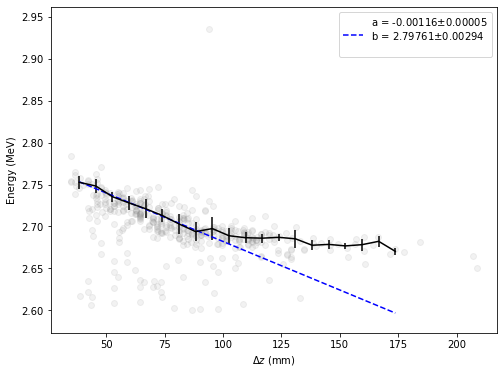

In [39]:
def dz_effect(enes, dz, nsigma = 2.5, xbin = 7):
    plt.scatter(dzs, enes, alpha = 0.1, c='grey');
    xs, ys, eys = pltext.hprofile_in_sigma(dzs, enes, nsigma = nsigma);
    plt.xlabel(r'$\Delta z$ (mm)'); plt.ylabel('Energy (MeV)');
    from scipy import optimize
    fun = lambda x, a, b: x * a + b
    par, upar = optimize.curve_fit(fun, xs[:xbin], ys[:xbin], sigma = eys[:xbin])
    upar = np.array([np.sqrt(upar[i, i]) for i in range(2)])
    ss = hfit.str_parameters(par, upar, ('a', 'b'), formate = '6.5f')
    plt.plot(xs, fun(xs, *par), c = 'blue', label = ss, ls = '--');
    plt.legend()

xsel = selections['ph']
print(xsel.info)
pltext.canvas(1, 1, 6, 8)
enes, dzs = dd[xsel].energy.values, dd[xsel].dz_track.values
dz_effect(enes, dzs)

z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & energy [2.6, 3.0]
blob right :  148
blob left  :  149


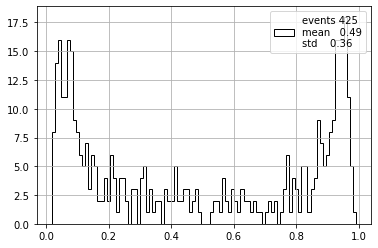

In [40]:
print(xsel.info)
pltext.hist(dd[xsel].blob1_eta, 100);
print('blob right : ', np.sum(selections['ph.br']))
print('blob left  : ', np.sum(selections['ph.bl']))

In [41]:
dd.columns

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min',
       'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
       'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
       'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
       'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor',
       'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks',
       'evt_nhits', 'S2eq', 'blob1_eta', 'blob2_eta'],
      dtype='object')

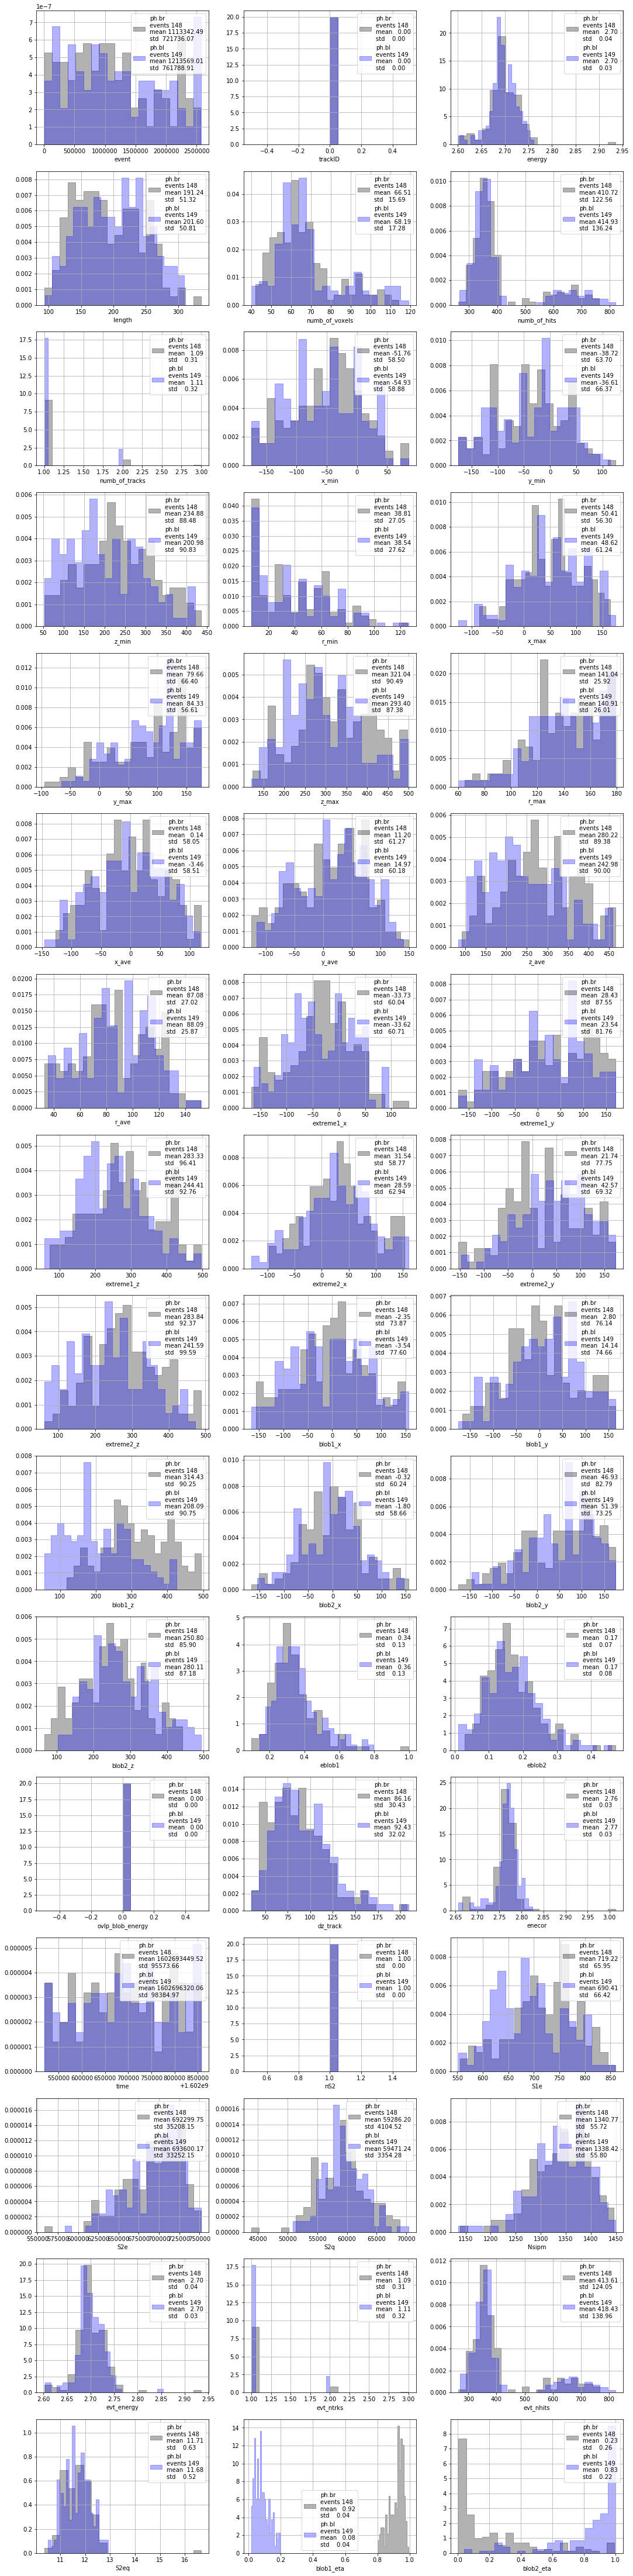

In [42]:
labels = list(dd.columns)

bins  = 20
subplot = pltext.canvas(len(labels), ny = 3)

sels = ['ph.br', 'ph.bl']
for i, label in enumerate(labels):
    subplot( i + 1)
    for sel in sels:
        xsel = selections[sel]
        pltext.hist(dd[xsel][label], bins, label = sel, alpha = 0.3, fill = True, density = True)
        plt.xlabel(label)
    plt.legend()

**Comments:**
    
   * There is no obvious differences in the variables between L/R blobs. 
    
   * There is of course differences in Z. R may have shorter DZ, tracks and slightly less blob energy
   
   * Why there is two groups of numb of hits?
    

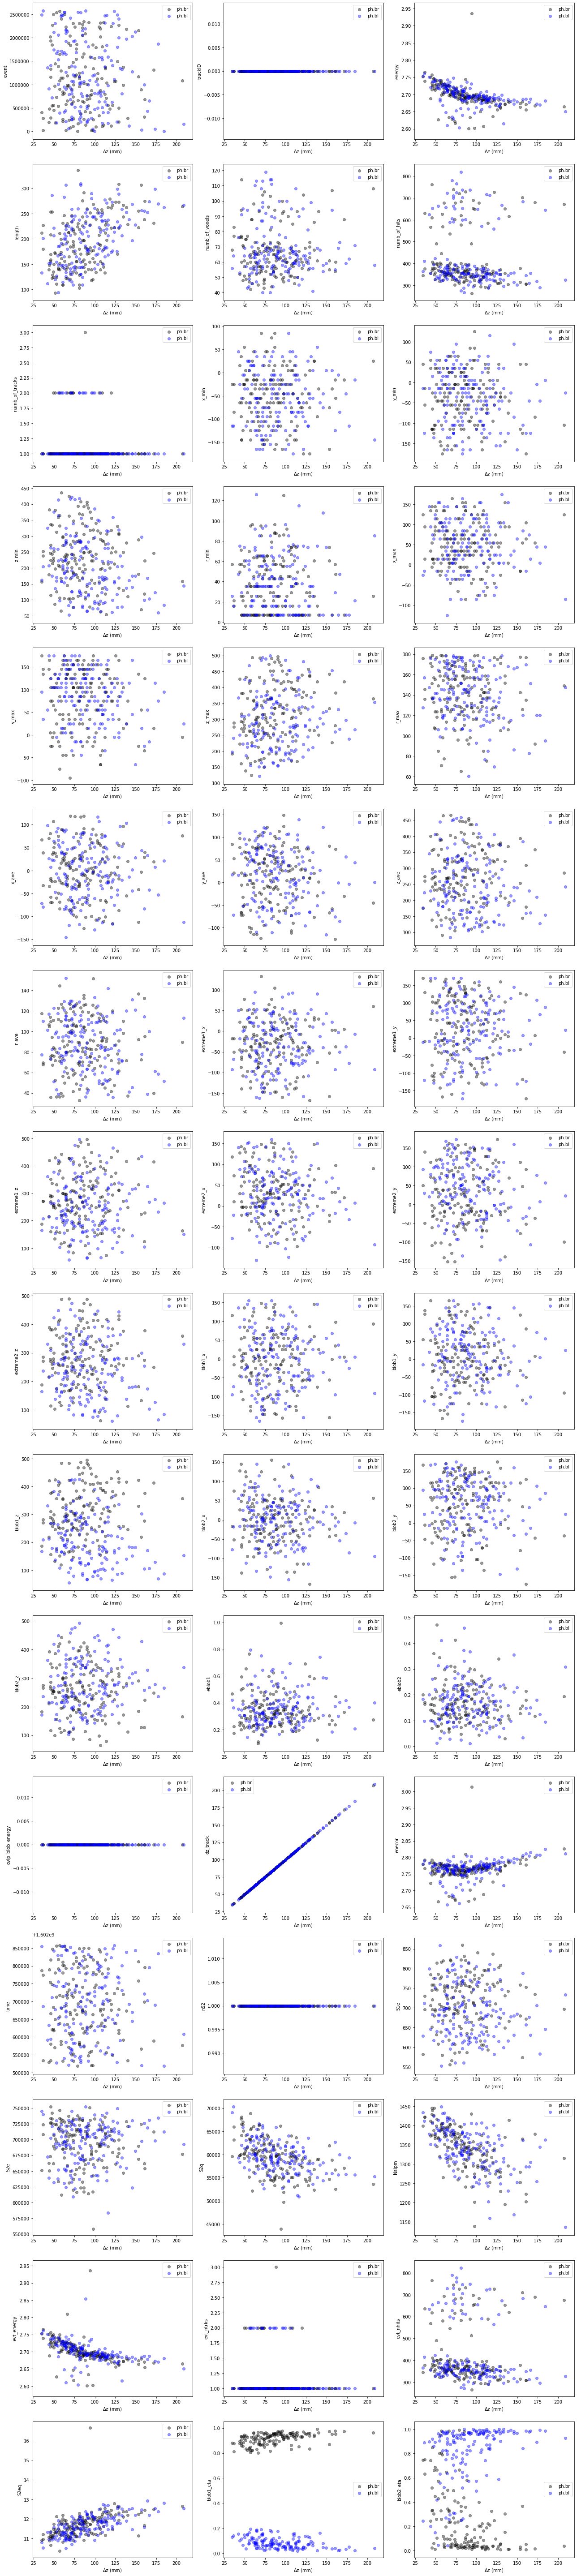

In [46]:
labels = list(dd.columns)

bins  = 20
subplot = pltext.canvas(len(labels), ny = 3)

sels = ['ph.br', 'ph.bl']
for i, label in enumerate(labels):
    subplot( i + 1)
    for sel in sels:
        xsel = selections[sel]
        plt.scatter(dd[xsel].dz_track, dd[xsel][label], alpha = 0.4, label = sel)
        plt.ylabel(label); plt.xlabel(r'$\Delta z$ (mm)')
    plt.legend()
    
plt.tight_layout()

## Compare $\Delta$z for Cs, Tl ds, Tl ph

In [77]:
elabel = 'enecor'
dd['dE'] = dd['energy'] - dd[elabel]
for channel in ['cs', 'ds', 'ph']:
    selections.logical_and(('fidutial', elabel+ '.' +channel + '.hard', 'dz_track.' + channel + '.hard'),  
                           channel +'.fidutial.hard')
    print('channel ', channel, ' : ', selections[channel+'.fidutial.hard'].info)

overwriting  cs.fidutial.hard  selection
channel  cs  :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [0.671, 0.691] & dz_track [8.0, 32.0]
overwriting  ds.fidutial.hard  selection
channel  ds  :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [1.63, 1.7] & dz_track [40.0, 80.0]
overwriting  ph.fidutial.hard  selection
channel  ph  :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [2.7, 2.9] & dz_track [40.0, 100.0]


In [109]:
def der_vs_dz(elabel = 'energy', e0label = 'enecor', selection = 'fidutial.hard'):

    channels = ['cs', 'ds', 'ph']

    pltext.canvas(1, 1, 8, 10)

    def pfit(xs, ys, eys):
        fun = lambda x, a, b: x * a + b
        par, upar = optimize.curve_fit(fun, xs, ys)
        upar = np.array([np.sqrt(upar[i, i]) for i in range(2)])
        ss = hfit.str_parameters(par, upar, ('a', 'b'), formate = '6.5f')
        plt.plot(xs, fun(xs, *par), label = ss, ls = '--');

    xs, ys, eys = [], [], []
    for i, channel in enumerate(channels):
        xsel = selections[channel + '.' + selection]
        print(channel + ' selection : ', xsel.info)
        ene0 = np.mean(dd[xsel][e0label].values)
        dere  = (dd[xsel][elabel]/ene0) - 1.
        alpha = 0.002 * (10**i)
        plt.scatter(dd[xsel].dz_track, dere, alpha = alpha)
        #xs, ys, eys = pltext.hprofile_in_sigma(dd[xsel].dz_track, dere, nbins = 20, label = channel)
        ixs, iys, ieys = pltext.hprofile(dd[xsel].dz_track, dere, nbins = 20, label = channel)
        xs += list(ixs); ys += list(iys); eys += list(ieys)
    pfit(np.array(xs), np.array(ys), np.array(eys))
    plt.legend(fontsize = 12);
    plt.grid(); plt.xlabel(r'$\Delta$z (mm)', fontsize = 14); plt.ylabel(r'$\Delta E/E$', fontsize = 14);
    
    return

cs selection :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [0.671, 0.691] & dz_track [8.0, 32.0]
ds selection :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [1.63, 1.7] & dz_track [40.0, 80.0]
ph selection :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [2.7, 2.9] & dz_track [40.0, 100.0]


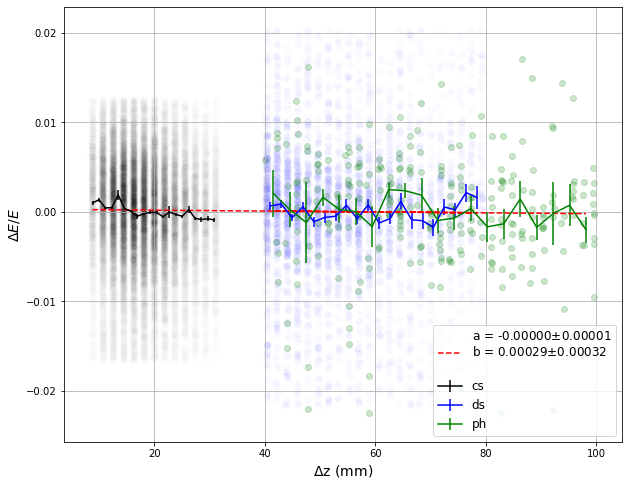

In [113]:
der_vs_dz('enecor');

## Other corrections

cs selection :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [0.671, 0.691] & dz_track [8.0, 32.0]
ds selection :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [1.63, 1.7] & dz_track [40.0, 80.0]
ph selection :  z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [2.7, 2.9] & dz_track [40.0, 100.0]


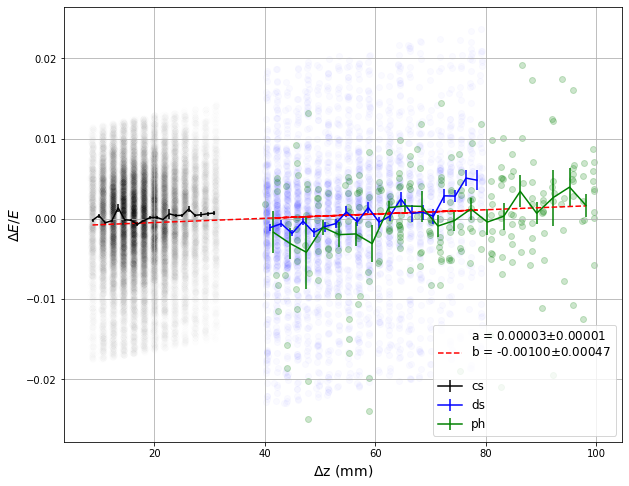

In [178]:
alpha = 4e-4
dd['enecor_test'] = bes.energy_correction(dd.energy, dd.dz_track, alpha)
der_vs_dz('enecor_test', 'enecor_test')

## Scan in alpha - correction

z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [1.55, 1.75]
z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [0.65, 0.71]
z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [0.0, 3.0] & nS2 [0.5, 1.5] & enecor [2.7, 2.9]


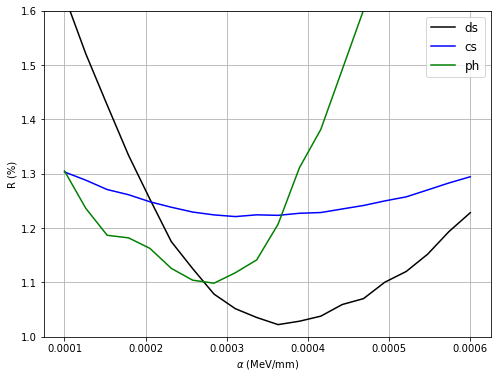

In [185]:
def r_alpha_scan(channel = 'ds'):
    xchannel =  channel if channel != 'ph' else 'ph.hard'
    xsel = selections.logical_and(('fidutial', 'enecor.' + xchannel))
    alphas = [i * 10**-4 for i in np.linspace(1., 6., 20)]

    xalphas, pars, upars = [], [], []
    for i, alpha in enumerate(alphas):
        dd['enecor_test'] = bes.energy_correction(dd.energy, dd.dz_track, alpha)
    
        try:
            ipars, iupars = hfit.hfit(dd[xsel].enecor_test, 100, 'gausline');
            pars.append(ipars); upars.append(iupars)
            xalphas.append(alpha)
        except:
            pass

    print(xsel.info)
    plt.plot(xalphas, [abs(235.*ipar[2]/ipar[1]) for ipar in pars], label = channel)
    plt.xlabel(r'$\alpha$ (MeV/mm)'); plt.ylabel('R (%)'); plt.grid();
    plt.legend()
    
pltext.canvas(1, 1, 6, 8)
r_alpha_scan('ds')
r_alpha_scan('cs')
r_alpha_scan('ph')
plt.legend(fontsize = 12); 
plt.ylim((1., 1.6));

## PH Left- Right